## KEY OBJECTIVE

#### ->Identify frequently co-occurring products in customer transactions.

#### ->Identify Central item for frequent associations.

#### ->Discover association rules that reveal meaningful connections between items.

#### ->Optimize product placement within the store based on association rules.

In [1]:
pip install mlxtend


Note: you may need to restart the kernel to use updated packages.


## LOADING LIBRARIES


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules



## wrangling the dataset

In [3]:
def wrangle(file_path):
    df = pd.read_csv(file_path)
    #CONVERTING DATE TO DATE TIME USING PANDAS
    df['Date'] = pd.to_datetime(df['Date'])
    #CREATING A YEAR COLUMN FROM DATE DATE COLUMN 
    df['item_count'] = df.groupby('Date')['itemDescription'].transform('nunique')


   
    return df
                     


In [4]:
df = wrangle('Market_Basket_Analysis_Groceries_dataset.csv')

C:\Users\dss\.ipython\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '21-07-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\dss\.ipython\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '19-09-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\dss\.ipython\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14-02-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\dss\.ipython\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '23-12-2015' in DD/MM/YYYY format. Provide format or specify infer_date

# EDA

In [5]:
df.head().set_index('Date')

,Member_number,itemDescription,item_count
Date,,,
2015-07-21,1808,tropical fruit,45
2015-05-01,2552,whole milk,35
2015-09-19,2300,pip fruit,32
2015-12-12,1187,other vegetables,37
2015-01-02,3037,whole milk,31


In [6]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

C:\Users\dss\AppData\Local\Temp\ipykernel_15816\4062314973.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
C:\Users\dss\AppData\Local\Temp\ipykernel_15816\4062314973.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))


,Member_number,Date,itemDescription,item_count
column type,int64,datetime64[ns],object,int64
null values (nb),0,0,0,0
null values (%),0.0,0.0,0.0,0.0


In [7]:
df.shape

(38765, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
 3   item_count       38765 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.2+ MB


In [9]:
df.describe()

,Member_number,item_count
count,38765.000000,38765.000000
mean,3003.641868,35.989320
std,1153.611031,6.277953
min,1000.000000,17.000000
25%,2002.000000,32.000000
50%,3005.000000,36.000000
75%,4007.000000,40.000000
max,5000.000000,59.000000


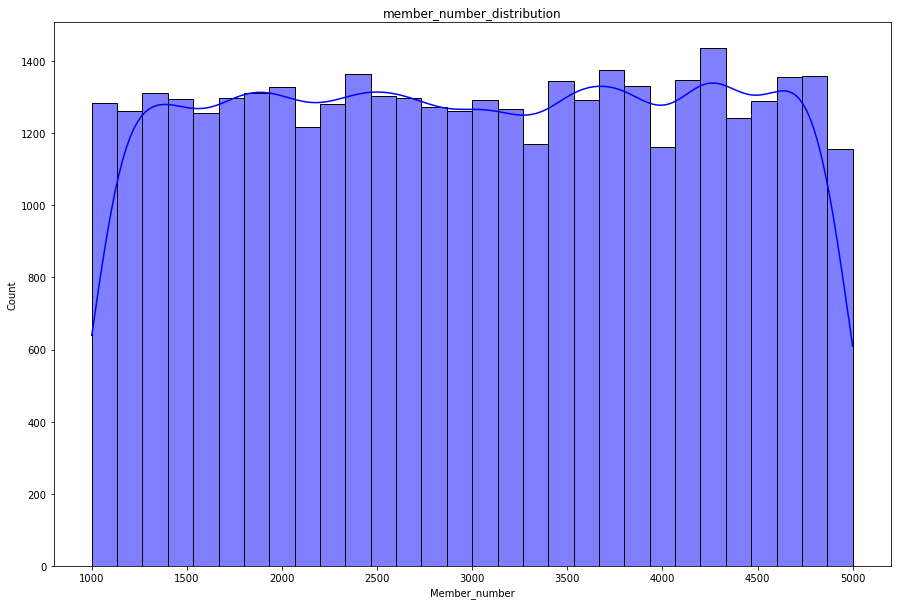

In [10]:
plt.figure(figsize =(15,10))
sns.histplot(df['Member_number'], bins=30, kde=True, color ="blue")
plt.title("member_number_distribution")
plt.show()

this chart show an uniform distribution of memeber_number column Since there is no significant dominant customer group, this analysis is will base on capture diverse purchasing behaviors across the entire customer base uncovering general patterns, the number of transactions and associations rather than focusing on specific customer segments. 

In [11]:
# using  z-scores to check the frequency of customer purchase of a particular item that are below and above mean.
df['item_count_zscore'] = (df['item_count'] - df['item_count'].mean()) / df['item_count'].std()
df.head(10)


,Member_number,Date,itemDescription,item_count,item_count_zscore
0,1808,2015-07-21,tropical fruit,45,1.435289
1,2552,2015-05-01,whole milk,35,-0.157586
2,2300,2015-09-19,pip fruit,32,-0.635449
3,1187,2015-12-12,other vegetables,37,0.160989
4,3037,2015-01-02,whole milk,31,-0.794737
5,4941,2015-02-14,rolls/buns,41,0.798139
6,4501,2015-08-05,other vegetables,43,1.116714
7,3803,2015-12-23,pot plants,40,0.638852
8,2762,2015-03-20,whole milk,40,0.638852
9,4119,2015-12-02,tropical fruit,34,-0.316874


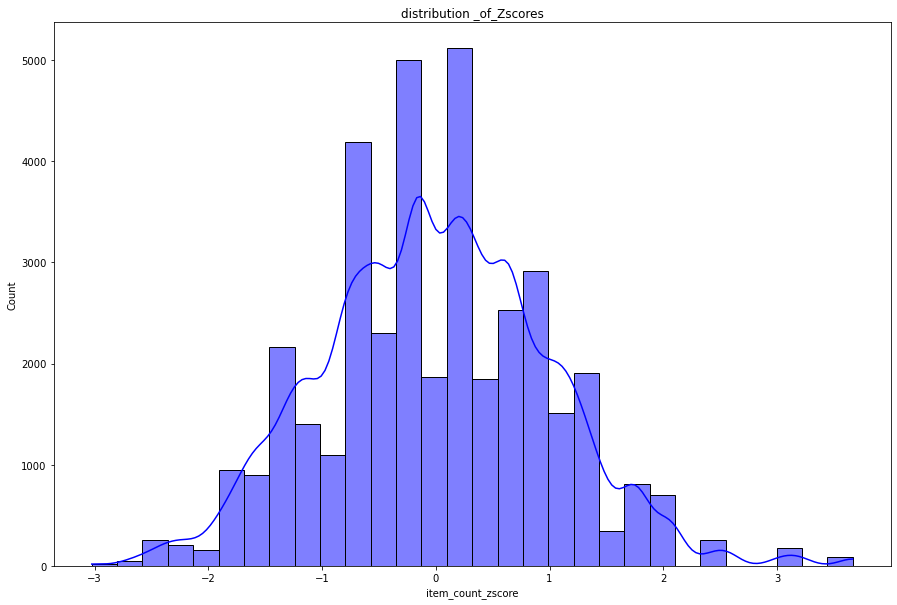

In [12]:
plt.figure(figsize =(15,10))
sns.histplot(df['item_count_zscore'], bins=30, kde=True, color ="blue")
plt.title("distribution _of_Zscores")
plt.show()

In [13]:
niche_item =df[df['item_count_zscore']<-2]
niche_item


,Member_number,Date,itemDescription,item_count,item_count_zscore
110,1095,2015-10-30,packaged fruit/vegetables,22,-2.228325
137,4760,2015-02-22,canned beer,22,-2.228325
151,2851,2015-03-16,rolls/buns,19,-2.706188
175,4559,2015-03-16,whole milk,19,-2.706188
215,4720,2015-02-22,beverages,22,-2.228325
...,...,...,...,...,...
38636,1625,2014-10-01,yogurt,20,-2.546900
38655,1041,2014-06-29,whole milk,21,-2.387613
38664,4126,2014-06-11,rolls/buns,20,-2.546900
38712,2325,2014-06-11,flour,20,-2.546900


In [14]:
niche_item.value_counts()

Member_number  Date        itemDescription      item_count  item_count_zscore
4152           2014-07-12  rolls/buns           21          -2.387613            2
1780           2015-10-13  canned fish          23          -2.069038            2
3879           2014-10-01  curd                 20          -2.546900            2
1700           2015-10-30  other vegetables     22          -2.228325            2
1872           2015-05-04  whole milk           22          -2.228325            2
                                                                                ..
2111           2014-07-12  tropical fruit       21          -2.387613            1
2128           2015-09-07  brown bread          21          -2.387613            1
                           chicken              21          -2.387613            1
                           soda                 21          -2.387613            1
4999           2014-09-04  semi-finished bread  23          -2.069038            1
Length: 6

Among the 682 items analyzed, comprising 1.75% of the dataset, those with low z-scores indicate a notably lower frequency of purchase. These items are representative of niche products and uncommon combinations that are infrequently included in customer baskets.

In [15]:
popular_staple =  df[df['item_count_zscore']>2]
popular_staple 

,Member_number,Date,itemDescription,item_count,item_count_zscore
46,2676,2015-08-15,rolls/buns,49,2.072440
125,4828,2015-08-08,sparkling wine,59,3.665316
145,3954,2015-01-21,frankfurter,56,3.187453
204,1232,2015-01-21,rolls/buns,56,3.187453
229,4509,2015-11-29,tropical fruit,51,2.391015
...,...,...,...,...,...
38604,2552,2014-06-20,hygiene articles,49,2.072440
38611,4310,2014-07-07,red/blush wine,52,2.550303
38672,4211,2014-03-04,whole milk,52,2.550303
38705,4871,2014-07-07,frozen fish,52,2.550303


In [16]:
popular_staple .value_counts()

Member_number  Date        itemDescription   item_count  item_count_zscore
3051           2015-11-29  other vegetables  51          2.391015             3
4701           2015-04-30  soda              49          2.072440             3
1792           2015-08-15  tropical fruit    49          2.072440             2
3752           2015-08-20  whole milk        49          2.072440             2
4657           2015-08-15  other vegetables  49          2.072440             2
                                                                             ..
2571           2014-07-07  pastry            52          2.550303             1
                           sliced cheese     52          2.550303             1
                           yogurt            52          2.550303             1
2580           2014-03-04  salad dressing    52          2.550303             1
4993           2015-01-21  chocolate         56          3.187453             1
Length: 970, dtype: int64

Out of the 990 items examined, constituting 2.6% of the item_count, item_count with high z-scores indicate a considerably higher frequency of purchase. These items serve as popular staples commonly found in many baskets.

In [17]:
frequent_item =df['itemDescription'].value_counts()
frequent_item

whole milk               2502
other vegetables         1898
rolls/buns               1716
soda                     1514
yogurt                   1334
                         ... 
rubbing alcohol             5
bags                        4
baby cosmetics              3
kitchen utensil             1
preservation products       1
Name: itemDescription, Length: 167, dtype: int64

In [18]:
 sol_20_item=frequent_item.head(20)

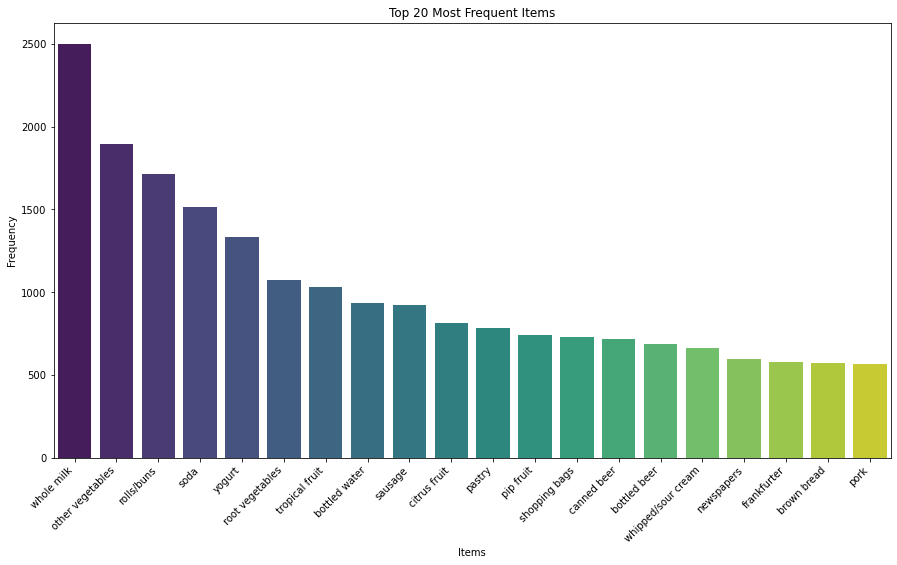

In [19]:
# Plot the top most frequent items
plt.figure(figsize=(15, 8))
sns.barplot(x=sol_20_item.index, y=sol_20_item.values, palette='viridis')
plt.title('Top 20 Most Frequent Items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [20]:
dff = df['itemDescription'] == ("whole milk")
dff.value_counts()

False    36263
True      2502
Name: itemDescription, dtype: int64

In [21]:
dff = df['itemDescription'] == ("pork")
dff.value_counts()

False    38199
True       566
Name: itemDescription, dtype: int64

In the presented bar chart, the highest sales were observed for whole milk, reaching approximately 2502 units, constituting around 6.45% of the total sales. Following closely, other vegetables accounted for 1898 units, while roll/buns trailed with 1716 units. Notably, pork recorded the lowest sales among the top 20 items, totaling 566 units.

In [22]:
sols_20_item =frequent_item.tail(20)

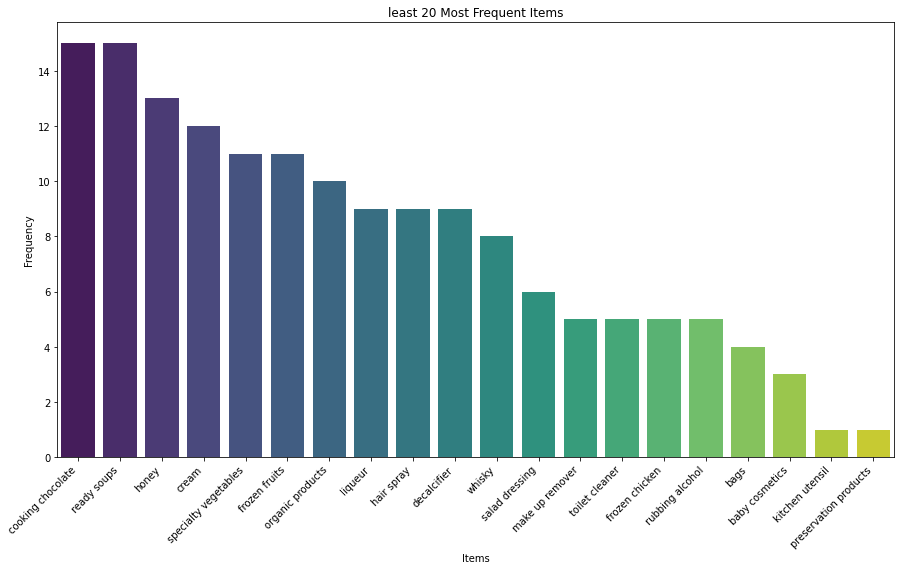

In [23]:
#Plot the least most frequent items
plt.figure(figsize=(15, 8))
sns.barplot(x=sols_20_item.index, y=sols_20_item.values, palette='viridis')
plt.title('least 20 Most Frequent Items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [24]:
dff = df['itemDescription'] == ("preservative products")
dff.value_counts()

False    38765
Name: itemDescription, dtype: int64

In [25]:
dff = df['itemDescription'] == ("cooking chocolate")
dff.value_counts()  

False    38750
True        15
Name: itemDescription, dtype: int64

In the basket market analysis, no preservation products or kitchen utensil  were sold, 4 bags were sold, and cooking chocolate, with a mere 15 units sold, ranked highest as one of the purchased items among the bottom 20.

In [26]:
# Creating unique transactions for each customer based on the items purchased by date
df['Transaction'] = df['Member_number'].astype(str) + '-' + df['Date'].astype(str)

In [27]:
# Crosstab is used to create a frequency table of the transactions
df_all_item = pd.crosstab(df['Transaction'], df['itemDescription'])
df_all_item .head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transaction,,,,,,,,,,,,,,,,,,,,,
1000-2014-06-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1000-2015-03-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1000-2015-05-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000-2015-07-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000-2015-11-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Encoding values to 0 and 1
    
df_basket = df_all_item .applymap(lambda x: 1 if x > 0 else 0)

# Generating associate rule using apriori algorithm 

0.005 minimum support was used to enable the discover of items which z-scores fall outside the expected range (-2 to 2), inorder to consider a lower support threshold and discover associations involving those less frequent items.

In [29]:
#Generate frequent itemsets with minimum support of 0.005 
frequent_itemsets = apriori(df_basket, min_support=0.005,use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values(by = 'zhangs_metric', ascending = False)
rules.head(10)

C:\Users\dss\.ipython\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,-0.000005,0.999874,-0.000702
1,(whole milk),(bottled beer),0.157923,0.045312,0.007151,0.045281,0.999330,-0.000005,0.999968,-0.000795
2,(canned beer),(whole milk),0.046916,0.157923,0.006015,0.128205,0.811821,-0.001394,0.965912,-0.195630
3,(whole milk),(canned beer),0.157923,0.046916,0.006015,0.038087,0.811821,-0.001394,0.990822,-0.215852
4,(citrus fruit),(whole milk),0.053131,0.157923,0.007151,0.134591,0.852259,-0.001240,0.973040,-0.154748
5,(whole milk),(citrus fruit),0.157923,0.053131,0.007151,0.045281,0.852259,-0.001240,0.991778,-0.170718
6,(whole milk),(domestic eggs),0.157923,0.037091,0.005280,0.033432,0.901341,-0.000578,0.996214,-0.115033
7,(domestic eggs),(whole milk),0.037091,0.157923,0.005280,0.142342,0.901341,-0.000578,0.981834,-0.102072
8,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146
9,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,0.000536,1.004579,0.118536


Milk as an antecedent has a strong associate with other items:
(whole milk) -> (bottled beer) and (bottled beer) -> (whole milk): These rules have perfect confidence (0.999), indicating a very strong association between these items. They are also the most frequent rules.
(whole milk) -> (canned beer) and (canned beer) -> (whole milk): While their confidence (0.811) is lower, the lift scores above 1 suggest a positive correlation.
Other rules with whole milk: Whole milk appears in 17 of the top 20 rules, suggesting it's a central item with frequent associations.
Notable Patterns:
Meat and Vegetables: Rules like (other vegetables) -> (frankfurter) and (sausage) -> (other vegetables) suggest a common pairing of meat and vegetables.
Breakfast Items: Rules like (whole milk) -> (domestic eggs) and (whole milk) -> (rolls/buns) point to potential breakfast combinations.

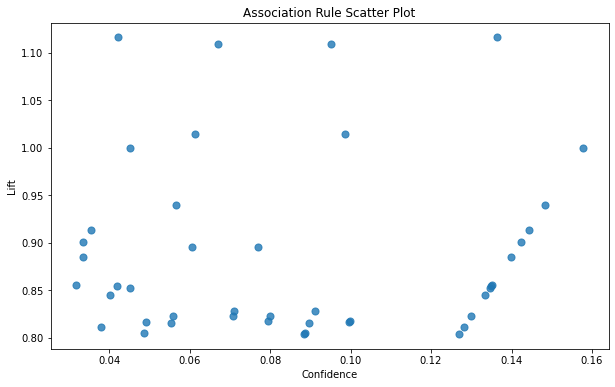

In [30]:

# Scatter plot with confidence and lift as axes
plt.figure(figsize=(10, 6))
plt.scatter(rules['confidence'], rules['lift'], s=50, alpha=0.8)
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Association Rule Scatter Plot')
plt.show()



In the market basket analysis, the scattered plot reveals areas characterized by high lift and confidence levels signifying robust and reliable associations. Given a support threshold of 0.005, this association occurs in approximately 0.5% of transactions, indicating a moderate level of co-occurrence. Items situated in the upper right quadrant warrant prioritization, as they exhibit a complementary relationship.


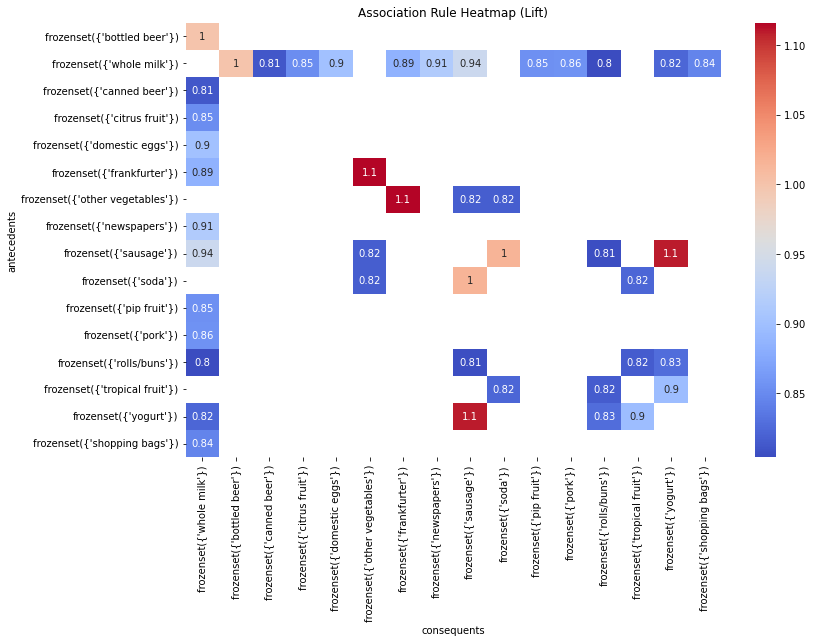

In [31]:
# Heatmap to visualize rule properties
rules_pivot = rules.pivot(index='antecedents', columns='consequents', values='lift')
plt.figure(figsize=(12, 8))
sns.heatmap(rules_pivot, annot=True, cmap='coolwarm')
plt.title('Association Rule Heatmap (Lift)')
plt.show()

People who buy other vegetables are 11.6% more likely to also buy frankfurters than expected by chance, The rule holds true in both directions, with similar metrics. This positive correlation suggests a complementary relationship between these items.same rules hold to yogurt and sausage, with a lift of 1.1 is a key indicator of this positive association. sausage and soda has a lift of 1.0 which is also a positive association and a complementary relationship similar metrics goes for milk and bottled beer. 

In [32]:
# Filter association rules for co-purchasing opportunities
rules_4_sales = rules[(rules['antecedents'].apply(len) == 1) & (rules['consequents'].apply(len) == 1)]

# Sort rules based on confidence and support
rules_4_sales = rules_4_sales.sort_values(by=['confidence', 'support'], ascending=False)
# Select top cross-sale recommendations
top_ass_sale = rules_4_sales.head(10)

# Display cross-sale recommendations
print("Central item for frequent associations.:")
for idx, row in top_ass_sale.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    print(f"Customers who purchased  '{antecedent}' also purchased '{consequent}'.")

Central item for frequent associations.:
Customers who purchased  'bottled beer' also purchased 'whole milk'.
Customers who purchased  'sausage' also purchased 'whole milk'.
Customers who purchased  'newspapers' also purchased 'whole milk'.
Customers who purchased  'domestic eggs' also purchased 'whole milk'.
Customers who purchased  'frankfurter' also purchased 'whole milk'.
Customers who purchased  'frankfurter' also purchased 'other vegetables'.
Customers who purchased  'pork' also purchased 'whole milk'.
Customers who purchased  'pip fruit' also purchased 'whole milk'.
Customers who purchased  'citrus fruit' also purchased 'whole milk'.
Customers who purchased  'shopping bags' also purchased 'whole milk'.


Several central items exhibit frequent associations with 'whole milk,' indicating significant co-purchasing patterns among customers. These associations highlight key items that are frequently bought together with 'whole milk,' providing valuable insights for marketing strategies, product placements, and customer preferences in the retail environment.

In [33]:
#creating a Zhangs_metric for more Intentional purchase 
rules_zhang= rules[rules['zhangs_metric'] > 0]

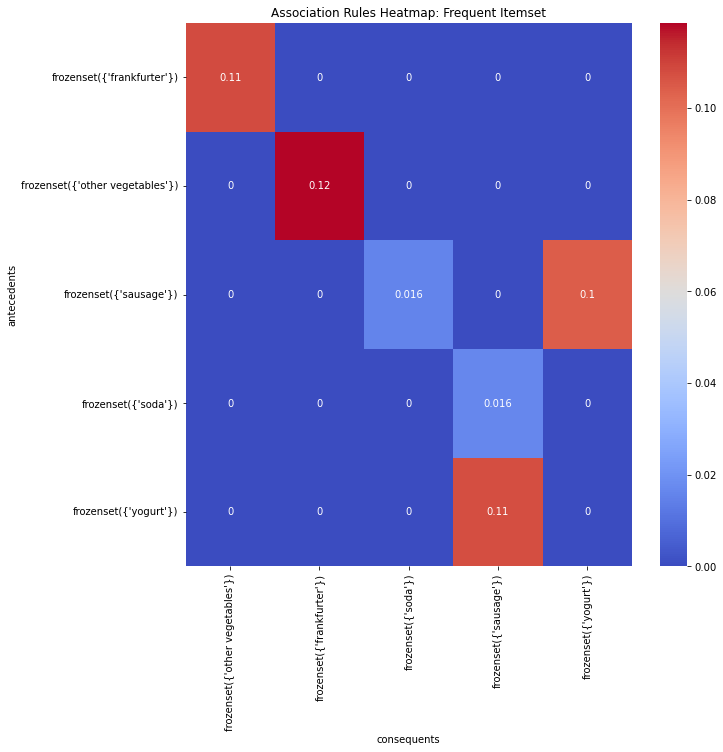

In [34]:
# Creating matrix and heatmap of for item with positive association and complementary relationship
association = rules_zhang.pivot(index='antecedents', columns='consequents', values='zhangs_metric').fillna(0)
plt.figure(figsize=(10, 10))
sns.heatmap(association, annot=True, cmap='coolwarm')
plt.title('Association Rules Heatmap: Frequent Itemset')
plt.show()

Pairs such as 'other vegetable' and 'frankfurter,' 'sausage' and 'soda,' and 'sausage' and 'yogurt' emerge as swiftly adopted combinations in the market. These pairings exhibit a reliable association and a robust complementary relationship, suggesting a strong inclination among customers to purchase these items together. This insight can guide strategic decisions for product placement and promotions to enhance customer satisfaction and drive sales

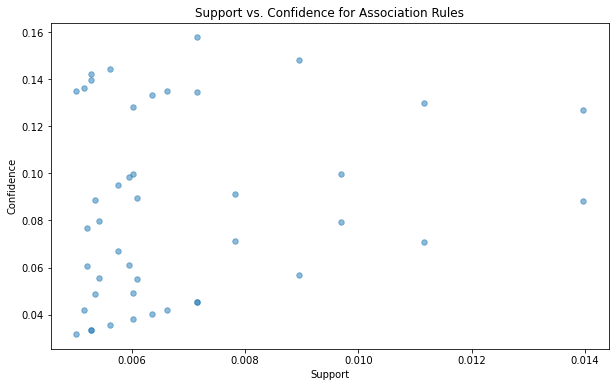

In [35]:
# Scatter plot of support vs. confidence for association rules
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, s=30)
plt.title('Support vs. Confidence for Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()



 ## experimenting with different support mining threshold

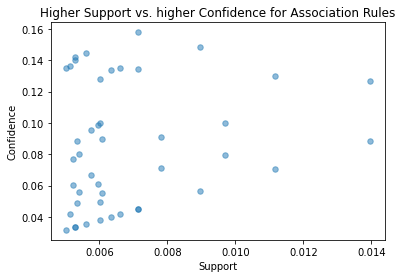

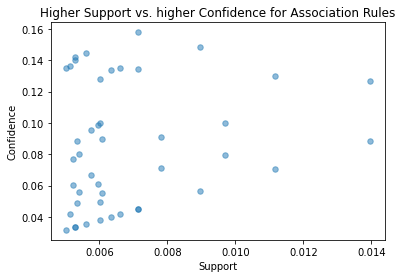

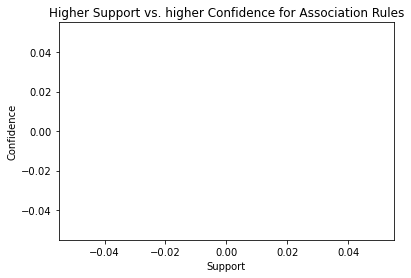

In [36]:
#This filters rules with confidence less than 0.10 and support greater than 0.014.
high_conf_high_supp_rules = rules[(rules['confidence'] < 0.50) & (rules['support'] < 0.014)]
plt.scatter(high_conf_high_supp_rules['support'], high_conf_high_supp_rules['confidence'], alpha=0.5, s=30)
plt.title('Higher Support vs. higher Confidence for Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()


#This filters rules with confidence less than 0.90 and support equal to 0.005 which is been used.
support_threshold = 0.005
high_conf_high_supp_rules = rules[(rules['confidence'] < 0.90) & (rules['support'] > support_threshold)]
plt.scatter(high_conf_high_supp_rules['support'], high_conf_high_supp_rules['confidence'], alpha=0.5, s=30)
plt.title('Higher Support vs. higher Confidence for Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()


#This filters rules with confidence less than 0.90 and support greater than 0.014.
high_conf_high_supp_rules = rules[(rules['confidence'] < 0.90) & (rules['support'] > 0.014)]
plt.scatter(high_conf_high_supp_rules['support'], high_conf_high_supp_rules['confidence'], alpha=0.5, s=30)
plt.title('Higher Support vs. higher Confidence for Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

Enforcing stringent rules in market basket analysis leads to increased specificity and reliability in the identified patterns. However, for our dataset when a higher support threshold exceeds 0.013% with a higher confidence, the rules become excessively strict, resulting in the absence of specific patterns and no discernible data displayed on the chart. This discrepancy prompted the adoption of a 0.005 support threshold for mining, as it yields more meaningful and actionable rules. The set of plots displays data points, indicating the presence of rules that meet the defined confidence and support criteria in the market basket analysis.

In [37]:
df_support = rules[rules['support']> 0.013]
df_support

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.97635,-0.224474
27,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.96455,-0.214986


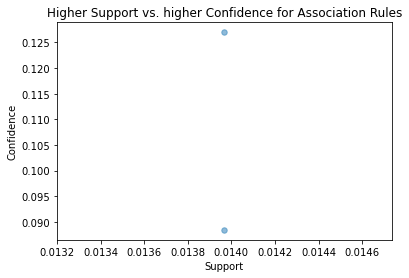

In [38]:
#This filters rules with confidence less than 0.90 and support greater than 0.013.
high_conf_high_supp_rules = rules[(rules['confidence'] < 0.90) & (rules['support'] >0.013)]
plt.scatter(high_conf_high_supp_rules['support'], high_conf_high_supp_rules['confidence'], alpha=0.5, s=30)
plt.title('Higher Support vs. higher Confidence for Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

Whole milk rolls/buns are the only two item that adhere to the most strict rule with support mining threshold up greater than  0.013 in market basket. If someone buys "whole milk," there's a 1.3968% chance they will also buy "rolls/buns." The confidence is 8.8447%, and the lift is 80.402. If someone buys "rolls/buns," there's a 1.3968% chance they will also buy "whole milk." The confidence is 12.6974%, and the lift is 80.4028. The negative values in the leverage, conviction, and zhangs_metric columns indicate that the observed co-occurrence is lower than expected if the items were independent.

## Recommendations

### Focus on broad customer base and popular items:

Leverage the uniform customer distribution: 
Develop marketing campaigns and promotions targeting the entire customer base instead of segmenting them. Highlight "popular items".
Personalize the shopping experience: Use customer purchase data to personalize product recommendations and promotions. Offer relevant coupons or discounts based on individual preferences.
Gather customer feedback: Conduct surveys or focus groups to understand customer motivations and preferences behind observed associations. This can help refine marketing strategies and product offerings.

Capitalize on high-selling items: Emphasize top-selling items like whole milk, vegetables, rolls/buns in promotions and Create eye-catching displays. Consider bundled offers of top selling items + niche items.

1. Healthy Breakfast Bundle:

Organic milk (niche)
Whole wheat rolls/buns (top-selling)
Fresh berries (niche)
Shopping bags (top-selling)
Yogurt (top-selling)
Honey (niche)
2. Family Comfort Bundle:

Frozen chicken (niche)
Shopping bags (top-selling)
Frozen vegetables (top-selling)
Canned soup (niche)
Baking soda (niche)
kitchen utensils(niche)
3. Grilling Party Bundle:

Sausage (top-selling)
Bottled beer (top-selling)
Shopping bags (top-selling)
Hot dog buns (top-selling)
cooking chocolate (niche)
Salad dressing (top-selling)
4. Cleaning Essentials Bundle:

Toilet cleaner (niche)
Decalcifier(niche)
Rubbing alcohol(niche)
Shopping bags (top-selling)
Paper towels (niche)
5. Pampering Package:

Baby wipes/lotion (niche)
Makeup remover (niche)
Shopping bags (top-selling)
Bath bombs (niche)
Liqueur (niche)
creams(niche)


### Promote complementary pairings:

Leverage on Milk Associations:
Leverage the strong association of whole milk with other items like bottled beer and canned beer. Create joint promotions or discounts to encourage customers to purchase these complementary products together.

Highlight associations in marketing and store layout: it is highly noteable that the topselling items are mostly in the food,and drink category.promote potential combinations like breakfast combination like Meat and Vegetables: other vegetables -> frankfurter and sausage -> other vegetables suggest.
Breakfast Items: whole milk -> domestic eggs and whole milk -> rolls/buns" in promotions, ads, and product canter placement.
Cross-sell and upsell: Recommend complementary items at checkout based on the customer's basket. Offer discounts, joint promotions or bundled offers to enhance customer satisfaction and increase sales bundles for buying paired items together.
### Utilize data insights strategically:

Optimize product placement: Arrange "popular items" and frequently paired items strategically in the store to encourage impulse purchases.
Personalize customer experiences: Use purchase history data to personalize recommendations and offers, encouraging repeat purchases and basket size growth.
Monitor and refine strategies: Track the effectiveness of your actions based on sales data and customer feedback. Continuously adapt your strategies for optimal results.
### Additional Recommendations:

Monitor and evaluate results: Track the effectiveness of implemented strategies based on sales data and customer feedback. Adjust your approach as needed to optimize results.
Utilize advanced data mining techniques: Consider exploring more sophisticated techniques like clustering or segmentation to uncover deeper insights into customer behavior and purchasing patterns.
Address niche items:While not dominant, niche items and uncommon combinations still exist. Consider targeted promotions or online marketplaces to cater to these specific customer segments.
Investigate basket analysis outliers: Explore the reasons behind items like reservation products, kitchen utensil, cooking chocolate having low etc sales despite being in the bottom 20 purchased items. This could reveal potential market shifts or untapped opportunities.
Analyze seasonality and trends: use time decompose analysis, consider potential seasonal variations in purchasing patterns and adjust strategies accordingly. Stay informed about industry trends to identify new opportunities.